<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Softmax-exercise" data-toc-modified-id="Softmax-exercise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Softmax exercise</a></span><ul class="toc-item"><li><span><a href="#Data-preparing" data-toc-modified-id="Data-preparing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data preparing</a></span></li><li><span><a href="#Base：Softmax-Classifier" data-toc-modified-id="Base：Softmax-Classifier-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Base：Softmax Classifier</a></span><ul class="toc-item"><li><span><a href="#related-equation" data-toc-modified-id="related-equation-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span><strong>related equation</strong></a></span></li><li><span><a href="#softmax-regression" data-toc-modified-id="softmax-regression-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span><strong>softmax regression</strong></a></span></li><li><span><a href="#code-test" data-toc-modified-id="code-test-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>code test</a></span></li></ul></li><li><span><a href="#Advanced" data-toc-modified-id="Advanced-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Advanced</a></span><ul class="toc-item"><li><span><a href="#Classifier-class" data-toc-modified-id="Classifier-class-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Classifier class</a></span></li><li><span><a href="#valitation" data-toc-modified-id="valitation-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>valitation</a></span></li><li><span><a href="#weight-visualization" data-toc-modified-id="weight-visualization-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>weight visualization</a></span></li></ul></li></ul></li></ul></div>

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


## Data preparing

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev

In [3]:
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Base：Softmax Classifier

### **related equation**

Softmax函数:$Softmax(a) = \frac{e^{a_{i}}}{\sum e^{a_{j}}}$,其对于输入的偏导:


$\frac{\partial Softmax}{\partial a_{i}} = S_{i}\ast (1-S_{i})$

$\frac{\partial Softmax}{\partial a_{j}} = -S_{i}\ast S_{j}$ 
        

其中$S_{i}$对应正确类别i的输出，$S_{j}$对应其余类别的softmax函数输出（输出是一个向量，对应C类）

$\frac{\partial Loss}{\partial W} = \frac{\partial Loss}{\partial sotfmax} \ast \frac{\partial softmax}{\partial a} \ast \frac{\partial a}{\partial W}$ 

其中：

$Loss = -{log\left ( softmax \right )}$

$a = W \ast X$


###  **softmax regression**
cs231n/classifiers 下的softmax.py，为了方便在jupyter notebook中编辑，不通过包调用啦!

In [4]:
from builtins import range
import numpy as np
from random import shuffle
from past.builtins import xrange

In [5]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    num_classes = W.shape[1]
    num_train = X.shape[0]

    for i in xrange(num_train):
        scores = X[i].dot(W)  # (1, D) dot (D, C) => (C, )
        scores = scores - max(scores)  # 减去max(scores)防止数据上溢/下溢
        # 单个样本所产生的损失值，Li = - log(softmax(scores))
        loss_i = -(scores[y[i]] - np.log(sum(np.exp(scores))))
        loss += loss_i

        # 前向传播的同时，记录 dW 用于反向传播
        for j in xrange(num_classes):
            softmax_output = np.exp(scores[j])/sum(np.exp(scores))
            if j == y[i]:
                dW[:, y[i]] += (softmax_output - 1) * X[i]  # 链式法则求导
            else:
                dW[:, j] += softmax_output * X[i]

    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    dW = dW/num_train + reg * W
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

**向量化后，用矩阵运算替代for循环可以大大节省时间**

In [6]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    num_classes = W.shape[1]
    num_train = X.shape[0]
    scores = X.dot(W)
    shift_scores = scores - np.max(scores, axis = 1).reshape(-1,1)
    softmax_output = np.exp(shift_scores)/np.sum(np.exp(shift_scores), axis = 1).reshape(-1,1)
    loss = -np.sum(np.log(softmax_output[range(num_train), list(y)]))
    loss /= num_train 
    loss +=  0.5* reg * np.sum(W * W)
  
    dS = softmax_output.copy()
    dS[range(num_train), list(y)] += -1
    dW = (X.T).dot(dS)
    dW = dW/num_train + reg* W
    pass

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

### code test
测试 softmax.py 

In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

# from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.394922
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ *Since the weight matrix W is uniform randomly selected, the predicted probability of each class is uniform distribution and identically equals 1/10, where 10 is the number of classes. So the cross entroy for each example is -log(0.1), which should equal to the loss.* 



In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.432966 analytic: -0.432966, relative error: 7.208693e-08
numerical: -5.090644 analytic: -5.090644, relative error: 3.247636e-09
numerical: 1.855640 analytic: 1.855640, relative error: 1.900349e-08
numerical: -0.834843 analytic: -0.834843, relative error: 1.929974e-08
numerical: -1.907642 analytic: -1.907642, relative error: 3.051011e-09
numerical: -0.358988 analytic: -0.358988, relative error: 7.738659e-08
numerical: -0.517367 analytic: -0.517367, relative error: 1.246271e-08
numerical: -0.701646 analytic: -0.701646, relative error: 5.052261e-09
numerical: -1.330508 analytic: -1.330508, relative error: 2.587872e-09
numerical: -2.090464 analytic: -2.090464, relative error: 8.478321e-09
numerical: -0.459511 analytic: -0.459511, relative error: 3.450144e-08
numerical: -1.707826 analytic: -1.707826, relative error: 2.156114e-08
numerical: -1.063348 analytic: -1.063348, relative error: 1.242918e-08
numerical: 2.644334 analytic: 2.644334, relative error: 1.704362e-08
numerical:

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.394922e+00 computed in 0.150774s
vectorized loss: 2.394922e+00 computed in 0.003710s
Loss difference: 0.000000
Gradient difference: 0.000000


## Advanced
### Classifier class
将其封装为完整的类，原本的代码在 cs231n.classifiers 下

In [10]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
           
            batch_idx = np.random.choice(num_train, batch_size, replace = True)
            X_batch =  X[batch_idx]
            y_batch = y[batch_idx]
            pass

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg) # loss, dW
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            
            # W =  W - learning_rate * dW
            self.W += - learning_rate * grad 
            pass

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis = 1)
        
        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

# 继承
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


### valitation
选择超参数, 使用 tqdm 打印循环执行进度条

In [11]:
from tqdm import tqdm
from tqdm import trange

In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
# from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-7, 5e-7]
#regularization_strengths = [5e4, 1e8]
regularization_strengths =[(1+0.1*i)*1e4 for i in range(-3,4)] + [(5+0.1*i)*1e4 for i in range(-3,4)]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
learning_rates = tqdm(learning_rates)
regularization_strengths = tqdm(regularization_strengths)
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters=2000)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax           
        results[(lr,rs)] = train_accuracy, val_accuracy
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

100%|██████████| 3/3 [03:51<00:00, 77.15s/it]

lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.344878 val accuracy: 0.344000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.351347 val accuracy: 0.372000
lr 1.000000e-07 reg 9.000000e+03 train accuracy: 0.356061 val accuracy: 0.373000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.350755 val accuracy: 0.375000
lr 1.000000e-07 reg 1.100000e+04 train accuracy: 0.360510 val accuracy: 0.360000
lr 1.000000e-07 reg 1.200000e+04 train accuracy: 0.360490 val accuracy: 0.364000
lr 1.000000e-07 reg 1.300000e+04 train accuracy: 0.360265 val accuracy: 0.377000
lr 1.000000e-07 reg 4.700000e+04 train accuracy: 0.327204 val accuracy: 0.349000
lr 1.000000e-07 reg 4.800000e+04 train accuracy: 0.327367 val accuracy: 0.336000
lr 1.000000e-07 reg 4.900000e+04 train accuracy: 0.336816 val accuracy: 0.345000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.325000 val accuracy: 0.336000
lr 1.000000e-07 reg 5.100000e+04 train accuracy: 0.328286 val accuracy: 0.346000
lr 1.000000e-07 reg 5.200000

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.379000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$True


$\color{blue}{\textit Your Explanation:}$思考SVM和Softmax regression损失函数的定义，对于SVM而言，其对分类正确的图片的不计入loss；但对与softmax而言，不论分类是否正确，loss总会是存在的，即使loss趋近于0，整体而言损失值变化了！



### weight visualization

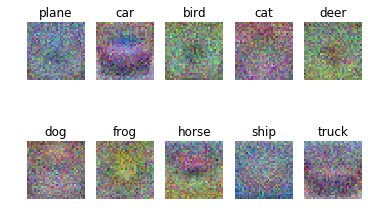

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])